# Model 3: Ranking Simulation

In [1]:
# Initialization
filename_probscores = 'pred2018_model2_noOpp'

# Ranks
rank_list = [1, 2, 3.5, 3.5, 6.5, 6.5, 6.5, 6.5, 10.5, 10.5, 10.5, 10.5, 14.5, 14.5, 14.5, 14.5, 18.5, 18.5, 18.5, 18.5, 22.5, 22.5, 22.5, 22.5]

In [2]:
# Ranking 2018
import numpy as np
ranking_worlds2018 = {(1): ['invictus gaming'], 
                      (2): ['fnatic'],
                      (3, 4): ['g2 esports', 'cloud9'],
                      (5, 8): ['kt rolster', 'royal never give up', 'edward gaming', 'afreeca freecs'],
                      (9, 12): ['flash wolves', 'vitality', 'team liquid', '100 thieves'],
                      (13, 16): ['phong vu buffalo', 'gen.g', 'g-rex', 'mad team'],
                      (17, 20): ['gambit esports', 'supermassive', 'infinity esports', 'detonation focusme'],
                      (21, 24): ['kabum', 'dire wolves', 'kaos latin gamers', 'ascension gaming']}
ranking_worlds2018_tmp = {team:np.mean(score) for score, teamlist in ranking_worlds2018.items() for team in teamlist}

## 0. Load libraries and define functions

### 0.1 General python functionality

In [3]:
# Functions
import random
import string
import numpy as np
import os
import pickle
import pandas as pd
import operator
import itertools
from numpy.random import choice
from collections import Counter
import statistics
from scipy import stats
import sklearn.metrics
import math
from matplotlib import cm

# Functions used for data visualization
import seaborn as sns
sns.set(context = "paper", font = "monospace")
import matplotlib.pyplot as plt

### 0.2 Custom functions

In [4]:
# Function used to create matchups between the teams of the input list
def team_combiner(list_of_teams):
    """
    Based on an input list this function returns unique combinations of the list elements
    
    :param: list_of_teams (list): A list capturing the different elements that need to be paired uniquely
    :return: (set) A set of tuples representing the unique pairs
    """
    # Initialization
    match_comb_set = []
    # Loop through the list of elements
    for team in list_of_teams:
        for opp in list_of_teams[::-1]:
            if team != opp and (team, opp) not in match_comb_set and (opp, team) not in match_comb_set:
                match_comb_set.append((team, opp))
    # Return the output
    return match_comb_set

In [5]:
# Function used to summarize the competition outcome dataframe returned by the game_outcome_simulator() function
def game_outcome_summarizer(game_outcome_df, team_strength_dict, top, return_df = False):
    """
    Function used to summarize the competition outcome dataframe returned by the game_outcome_simulator() function
    :param: game_outcome_df (pandas df)
    :param: team_strength_dict (dict): Dictionary capturing the different parameters for each team that need to be plugged 
                                       into the pdf used for outcome simulation.
    :param: top (int): The top teams with the highest win rate that are allowed to go to the next round
    :param: return_df (bool): Indicator to express whether the pandas df defining the summary of the competition should 
                              be returned in the output
                              
    :return: [IF return_df] (DataFrame) Dataframe capturing the summary of the competition results
             [ELSE] (list) List containing the top teams with the highest win rate
    """
    # Initialization
    team_list, wins_list, loss_list, tie_list, total_score_list, win_rate_list, games_played_list = [], [], [], [], [], [], []

    # Data summarization by looping through simulator returned df
    for t in list(team_strength_dict):
        wins, losses, ties, total, games_played = 0, 0, 0, 0, 0
        # Extract results for specific team
        for (team, opp), (team_score, opp_score) in zip(game_outcome_df['Teams competing'], game_outcome_df['Match outcome']):
            if t == team:
                if team_score > opp_score:
                    wins += 1
                elif team_score < opp_score:
                    losses += 1
                else:
                    ties += 1
                total += team_score
                games_played += 1
            elif t == opp:
                if team_score < opp_score:
                    wins += 1
                elif team_score > opp_score:
                    losses += 1
                else:
                    ties += 1
                total += opp_score
                games_played += 1
        # Store relevant information in lists
        team_list.append(t)
        wins_list.append(wins)
        loss_list.append(losses)
        tie_list.append(ties)
        total_score_list.append(total)
        try:
            win_rate_list.append((total/games_played)*100)
        except:
            win_rate_list.append(0)
        games_played_list.append(games_played)

    # Create summarizing df
    summary_df = pd.DataFrame({'Team': team_list, 'Wins': wins_list, 'Losses': loss_list,
                               'Ties': tie_list, "Total": total_score_list, "Win rate": win_rate_list, 
                               'Games played': games_played_list})
    
    # Return the teams with the highest win rates
    sorted_summary_dict = sorted(dict(zip(team_list, win_rate_list)).items(), key=operator.itemgetter(1))
    if return_df:
        return summary_df 
    else:
        return [k for k, v in sorted_summary_dict][::-1]
        #return [k for k, v in sorted_summary_dict[-top:]][::-1]

In [6]:
# Function used to describe the binomial model used for simulation
def binomial_model(strength_team, strength_opp):
    """
    :param: strength_team (float): Value between 0 and 1 reflecting the current strength of a team
    :param: strength_opp (float): Value between 0 and 1 reflecting the current strength of the opponent
    
    :return: (list) A list capturing the simulated standing 
    """
    # Simulate the game outcome untill there is a conclusive outcome
    outcome_team, outcome_opp = np.random.binomial(1, strength_team, 1)[0], np.random.binomial(1, strength_opp, 1)[0]
    while outcome_team == outcome_opp:
        outcome_team, outcome_opp = np.random.binomial(1, strength_team, 1)[0], np.random.binomial(1, strength_opp, 1)[0]  
    return [outcome_team, outcome_opp]

In [7]:
# Function used to simulate the outcome of a competion based on a predefined list of params and rounds/ games played 
# during the competition
def game_outcome_simulator(team_strength_dict, top = 2, matches_per_round = 2, games_per_match = 2, model = binomial_model):
    """
    Function used to simulate the outcome of a competion based on a predefined list of params and rounds/ games played
    during the competition
    
    :param: team_strength_dict (dict): Dictionary capturing the different parameters for each team that need to be plugged 
                                       into the pdf used for outcome simulation.
    :param: top (int): The top teams with the highest win rate that are allowed to go to the next round
    :param: matches_per_round (int): The number of matches played per round
    :param: games_per_match (int): The numbe of games played per match
    :param: model (func): the model used for game outcome simulation
    
    :return: (list) The top teams that go to the next round
    """
    # Initialization
    teams_involved_list, game_outcome_list = [], []
    # Extract set with unique list element pairs
    for team, opp in team_combiner(list(team_strength_dict)):
        for match in range(matches_per_round):
            for game in range(games_per_match):
                teams_involved_list.append([team, opp])
                game_outcome_list.append(model(team_strength_dict[team], team_strength_dict[opp]))  
    # Create pandas outcome df
    game_outcome_df =  pd.DataFrame({'Teams competing': teams_involved_list, 'Match outcome': game_outcome_list})
    
    # Extract the top best teams
    #print (game_outcome_summarizer(game_outcome_df, team_strength_dict, top))
    #return game_outcome_df, game_outcome_summarizer(game_outcome_df, team_strength_dict, top, True)
    return game_outcome_summarizer(game_outcome_df, team_strength_dict, top) 

In [8]:
# Helperfunction used to quickly create a dictionary matching a team with its corresponding strength estimation
def matching_dict_creator(pd_df, team_filter, ML_model):
    return dict(zip(pd_df[pd_df['team'].isin(team_filter)]['team'], pd_df[pd_df['team'].isin(team_filter)][ML_model]))

In [9]:
# Function used to extract rankings for the WORLDS competition
def worlds_ranking_extractor(playin_seed, pd_df, ML_model):
    """
    :param: playin_seed (list of lists): A list of lists capturing the teams that obtained a seed in the playin
    :param: pd_df (DataFrame): The dataframe capturing the strength parameters of the teams
    :param: ML_model (str): The name of the machine learning model from which the strength parameters will be extracted
    
    :return: (dict) A dictionairy mapping the rank with the correspondinglist of teams that can be mapped to that rank
    """
    # Initialize ranking dictionary
    rank_dict, ranks = dict(), [(21, 24), (17, 20), (13, 16), (9, 12), (5, 8), (3, 4), (2), (1)]

    # ------------ PLAY-IN STAGE -----------
    # i. Simulate outcome First round Play-In
    playin_round1_first, playin_round1_second, playin_round1_last = [], [], []
    for group in playin_seed: 
        first, second, last = game_outcome_simulator(matching_dict_creator(pd_df, group, ML_model))
        playin_round1_first.append(first)
        playin_round1_second.append(second)
        playin_round1_last.append(last)
    # Save ranking 
    rank_dict[ranks[0]] = playin_round1_last
    
    # ii. Simulate outcome Second round Play-In
    playin_round2_first, playin_round2_last = [], []
    for group in list(zip(random.sample(playin_round1_first, 4), random.sample(playin_round1_second, 4))):
        first, last = game_outcome_simulator(matching_dict_creator(pd_df, group, ML_model), matches_per_round = 1, games_per_match = 5)
        playin_round2_first.append(first)
        playin_round2_last.append(last)
    # Save ranking 
    rank_dict[ranks[1]] = playin_round2_last
    # Save teams advancing to the groupstage
    random_teams_playin = random.sample(playin_round2_first, 4)
    
    # ----------- GROUP STAGE -----------
    
    # Define the different pools from the Group stage
    teams_groupstage = [t for t in pd_df.team if t not in [k for l in playin_seed for k in l]]
    random_teams_groupstage = random.sample(teams_groupstage, len(teams_groupstage))
    
    # i. Group assignment before competition (- very messy function for matching playin teams with groupstage ones)
    teller_pi, group_list, groupstage_round1_groups = 0, [], []
    for teller_g, team_g in enumerate(random_teams_groupstage):
        group_list.append(team_g)
        if (teller_g-1) % 3 == 0 and teller_g != 0:
            if teller_g == 1:
                group_list.append(random_teams_groupstage[len(random_teams_groupstage)-1])
            group_list.append(random_teams_playin[teller_pi])
            groupstage_round1_groups.append(group_list)
            teller_pi += 1
            group_list = [] 
            
    # ii. Simulate outcome First round GroupStage
    groupstage_round1_first, groupstage_round1_second, groupstage_round1_third, groupstage_round1_fourth= [], [], [], []
    for group in groupstage_round1_groups: 
        first, second, third, fourth = game_outcome_simulator(matching_dict_creator(pd_df, group, ML_model))
        groupstage_round1_first.append(first)
        groupstage_round1_second.append(second)
        groupstage_round1_third.append(third)
        groupstage_round1_fourth.append(fourth)
    # Save ranking 
    rank_dict[ranks[2]] = groupstage_round1_fourth
    rank_dict[ranks[3]] = groupstage_round1_third
    
    # iii. Simulate outcome Knockout round GroupStage (Quarterfinals)
    groupstage_qf_first, groupstage_qf_last = [], []
    for group in list(zip(random.sample(groupstage_round1_first, 4), random.sample(groupstage_round1_second, 4))):
        first, last = game_outcome_simulator(matching_dict_creator(pd_df, group, ML_model), matches_per_round = 1, games_per_match = 5)
        groupstage_qf_first.append(first)
        groupstage_qf_last.append(last)
    # Save ranking 
    rank_dict[ranks[4]] = groupstage_qf_last
    
    # iv. Simulate outcome Knockout round GroupStage (Semifinals)
    random_teams_groupstage_qf = random.sample(groupstage_qf_first, 4)
    groupstage_sf_first, groupstage_sf_last = [], []
    for group in list(zip(random.sample(random_teams_groupstage_qf[:int(len(random_teams_groupstage_qf)/2)], 2), random.sample(random_teams_groupstage_qf[-(int(len(random_teams_groupstage_qf)/2)):], 2))):
        first, last = game_outcome_simulator(matching_dict_creator(pd_df, group, ML_model), matches_per_round = 1, games_per_match = 5)
        groupstage_sf_first.append(first)
        groupstage_sf_last.append(last)
    # Save ranking 
    rank_dict[ranks[5]] = groupstage_sf_last
    
    # v. Save ranking (FINALS!!!)
    winner , loser  = game_outcome_simulator(matching_dict_creator(pd_df, groupstage_sf_first, ML_model), 
                                       matches_per_round = 1, games_per_match = 5)
    rank_dict[ranks[6]] , rank_dict[ranks[7]]  = [winner], [loser]

    return rank_dict

In [10]:
### Function used to transform the ranking dictionary to a format appropriate for further analysis
def rank_dict_transformer(rank_dict):
    """
    :param: rank_dict (dict) Dictionary mapping the rank with the corresponding list of teams occupying that rank
    :return: (set) A set of tuples, each capturing the team ans its corresponding rank
    """
    # Transform dictionary to set op tuples
    return {(team, np.mean(key)) for key, team_list in rank_dict.items() for team in team_list}

In [11]:
### Function used to simulate the worlds competition ranking several times
def worlds_ranking_simulator(playin_seed, pd_df, ML_model, n_simulations):
    """
    :param: playin_seed (list of lists): A list of lists capturing the teams that obtained a seed in the playin
    :param: pd_df (DataFrame): The dataframe capturing the strength parameters of the teams
    :param: ML_model (str): The name of the machine learning model from which the strength parameters will be extracted
    
    :return: (dict) A dictionairy mapping the simulation number with the corresponding rank-dictionary 
    """
    return {i:rank_dict_transformer(worlds_ranking_extractor(playin_seed, pd_df, ML_model)) for i in range(n_simulations)}

In [12]:
### Function used to extract create a summary table that captures the probability of the teams to reach a certain competition stage
def simulation_summary_table_creator(rank_simulation_dict):
    """
    :param: rank_simulation_dict (dict): A dictionary matching the ID's with the set containing the team and 
            its corresponding rank resulting from the simulation
            
    :return: (dict) Dictionary mapping capturing the probability of a team going to the quarterfinals, semifinals, finals and 
                    winning the final competition
    """
    # Initialization
    team_list = [team for team, score in rank_simulation_dict[0]]
    quarter_prob, semi_prob, finals_prob, winner_prob = [], [], [], []
    # Loop through the different teams
    for team in team_list:
        quarter_team_prob, semi_team_prob, finals_team_prob, winner_team_prob = 0, 0, 0, 0
        # Extract team based probability of reaching certain place
        for ID, ID_ranks in rank_simulation_dict.items():
            for team_i, score in list(ID_ranks):
                if team == team_i:
                    if score in [6.5, 3.5, 2, 1]:
                        quarter_team_prob += 1
                    if score in [3.5, 2, 1]:
                        semi_team_prob += 1
                    if score in [2, 1]:
                        finals_team_prob += 1
                    if score == 1:
                        winner_team_prob += 1
        # Calculate expected probability
        quarter_prob.append(quarter_team_prob/len(rank_simulation_dict))
        semi_prob.append(semi_team_prob/len(rank_simulation_dict))
        finals_prob.append(finals_team_prob/len(rank_simulation_dict))
        winner_prob.append(winner_team_prob/len(rank_simulation_dict))
    # Return pandas df
    return pd.DataFrame({'Team': team_list,
                         'Quarterfinals': quarter_prob,
                         'Semifinals': semi_prob,
                         'Finals': finals_prob,
                         'Winner': winner_prob})

In [13]:
### Function used to extract create a summary table that captures the probability of the teams to reach a certain competition stage
def conditional_probability_creator(rank_simulation_dict, team_list):
    """
    :param: rank_simulation_dict (dict): A dictionary matching the ID's with the set containing the team and 
            its corresponding rank resulting from the simulation
            team_list (list): List capturing the teams you want to be represented by the visualization
            
    :return: (dict) Dictionary mapping capturing the probability of a team going to the quarterfinals, semifinals, finals and 
                    winning the final competition
    """
    # Initialization
    quarter_cond_prob, semi_cond_prob, finals_cond_prob, winner_cond_prob = [], [], [], []
    # Loop through the different teams
    for team in team_list:
        quarter_team_prob, semi_team_prob, finals_team_prob, winner_team_prob = 0, 0, 0, 0
        quarter_semi_team_prob, semi_finals_team_prob, finals_winner_team_prob = 0, 0, 0
        # Extract team based probability of reaching certain place
        for ID, ID_ranks in rank_simulation_dict.items():
            for team_i, score in list(ID_ranks):
                if team == team_i:
                    if score in [3.5, 2, 1]:
                        quarter_semi_team_prob += 1
                    if score in [6.5, 3.5, 2, 1]:
                        quarter_team_prob += 1
                    if score in [2, 1]:
                        semi_finals_team_prob += 1
                    if score in [3.5, 2, 1]:
                        semi_team_prob += 1
                    if score == 1:
                        finals_winner_team_prob += 1
                    if score in [2, 1]:
                        finals_team_prob += 1
        # Calculate expected probability
        quarter_cond_prob.append((quarter_semi_team_prob/len(rank_simulation_dict))/ (quarter_team_prob/len(rank_simulation_dict)))
        semi_cond_prob.append((semi_finals_team_prob/len(rank_simulation_dict))/ (semi_team_prob/len(rank_simulation_dict)))
        finals_cond_prob.append((finals_winner_team_prob/len(rank_simulation_dict))/ (finals_team_prob/len(rank_simulation_dict)))
    # Return pandas df
    return pd.DataFrame({'Team': team_list,
                         'Quarterfinals': quarter_cond_prob,
                         'Semifinals': semi_cond_prob,
                         'Finals': finals_cond_prob})

In [14]:
### Function used to extract the most occurring rank sequence based on the simulation
def most_occuring_rank(rank_simulation_dict):
    """
    :param: rank_simulation_dict (dict): A dictionary matching the ID's with the set containing the team and 
            its corresponding rank resulting from the simulation
            
    :return: (dict) Dictionary mapping the ID with the percentage of occurance of double rankings in the input dictionary
    """
    # Initialization
    most_occuring_rank_dict, id_set = dict(), set()
    # Loop through the different id's and detect double matches in rankings
    for ID1, ID1_ranks in rank_simulation_dict.items():
        teller = 1
        for ID2, ID2_ranks in zip(list(rank_simulation_dict.keys())[ID1+1:], list(rank_simulation_dict.values())[ID1+1:]):
            if ID1_ranks == ID2_ranks:
                teller += 1
                id_set.add(ID2)
        # Save id's and occurrance rate of double rankings in dictionary
        if ID1 not in most_occuring_rank_dict and ID1 not in id_set and teller != 1:
            most_occuring_rank_dict[ID1] = teller/len(rank_simulation_dict)*100
    # Return dictionary
    return most_occuring_rank_dict

In [15]:
### Function used to calulate the mean/mode rank of the teams based on the simulation
def ranking_summary_creator(rank_simulation_dict, mean = True):
    """
    :param: rank_simulation_dict (dict): A dictionary matching the ID's with the set containing the team and 
            its corresponding rank resulting from the simulation
            
    :return: (dict) Dictionary capturing the mean rank per team based on all simulations
    """
    # Initialization
    team_list, summary_dict = list({t for t, s in list(rank_simulation_dict[0])}), dict()
    for team_id in team_list:
        score_list = []
        for ID, rank_dict in rank_simulation_dict.items():
            for team, score in list(rank_dict):
                if team == team_id:
                    score_list.append(score)
        # Summary statistic calculation
        if mean:
            summary_dict[team_id] = np.mean(score_list)
        else:
            summary_dict[team_id] = stats.mode(score_list)[0][0]
    return summary_dict

In [16]:
### Function used for ranking visualization
def rank_visualizer(rank_dict, title):
    """
    :param: rank_dict (dict): Dictionary mapping each team with its corresponding rank
    """
    sorted_cnt = sorted(Counter(rank_dict).items(), key=operator.itemgetter(1))[::-1]
    plt.barh(range(1, len(sorted_cnt)+1), [score for label, score in sorted_cnt], 
                     tick_label = list([label for label, score in sorted_cnt]),
                     color = 'cornflowerblue', 
                     edgecolor = 'steelblue')
    plt.ylabel('Team')
    plt.xlabel('Rank')
    plt.title(title)
    plt.show()    

In [17]:
### Function used to return a summary for numeric variables
def SummaryNumericVar(list_of_values, title):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    """
    
    # Title varibale
    print("="* 100, "\nOverview of variable: ", title, "\n", "="*100)

    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x = list_of_values, bins='auto', color= '#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(top=np.ceil(n.max() / 10) * 10 if n.max() % 10 else n.max() + 10)
    plt.show()

    # Print summary statistics
    print("-"*20, "\nSummary statistics:\n", "-"*20)
    print("Minimum value:", min(list_of_values))
    print("Mean:", round(statistics.mean(list_of_values), 4))
    print("Standard deviation:", round(statistics.stdev(list_of_values), 4))
    print("Median:", round(statistics.median(list_of_values), 4))
    print("Maximal value:", max(list_of_values))

    # Plot boxplot
    plt.boxplot(list_of_values, 0, 'grey', 0)
    plt.xlabel('Value')
    plt.title(title)
    plt.show()

    # Present outliers
    print("-"*20, "\nOutlier detection:\n", "-"*20)
    print("List of outliers:", {round(value,2) for z_score, value in zip(np.abs(stats.zscore(list_of_values)), list_of_values) if z_score > 3})

    # Check for normally distributed
    stats.probplot(list_of_values, dist="norm", plot= plt)
    plt.show()

    # Statistics to check normality
    print("-"*20, "\nCheck for normal distribution:\n", "-"*20)
    print("Skewedness:", round(stats.skew(list_of_values), 4))
    print("Kurtosis:", round(stats.kurtosis(list_of_values), 4))

## 1. Load preprocessed data in environment

### 1.1 Load standardized data

In [18]:
# Load pickle
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + filename_probscores + '.pickle', 'rb') as f:
    data_probscores = pickle.load(f)
data_probscores.rename(columns={'Team': 'team'}, inplace=True)

In [19]:
# Visualize data
data_probscores

,lasso,ridge,result,team
g2 esports,0.515072,0.528435,0.571429,g2 esports
afreeca freecs,0.494044,0.514657,0.333333,afreeca freecs
team liquid,0.292842,0.389593,0.400000,team liquid
vitality,0.437653,0.431418,0.400000,vitality
royal never give up,0.738973,0.623168,0.625000,royal never give up
supermassive,0.574556,0.522281,0.600000,supermassive
fnatic,0.663764,0.565452,0.600000,fnatic
infinity esports,0.368688,0.385986,0.500000,infinity esports
mad team,0.356714,0.358662,0.000000,mad team
flash wolves,0.697183,0.577614,0.500000,flash wolves


In [20]:
# Intermediate summary
print("In total the dataset captures information from", len(data_probscores), "observations with", len(data_probscores.columns), "columns.")

In total the dataset captures information from 24 observations with 4 columns.


## 2. Ranking simulation

### 2.1 Initialization

In [21]:
# Initialization
ML_model = 'lasso'
ranks = [(21, 24), (17, 20), (13, 16), (9, 12), (5, 8), (3, 4), (2), (1)]
rank_dict = dict()

In [22]:
# Define the different pools from the Play-In stage
playin_round1_groups = [['edward gaming', 'infinity esports', 'dire wolves'],
                        ['g2 esports', 'supermassive', 'ascension gaming'],
                        ['cloud9', 'detonation focusme', 'kabum'],
                        ['g-rex', 'gambit esports', 'kaos latin gamers']]

### 2.2 Simulate ranking

In [23]:
# Ranking simulations
simulations_worlds = worlds_ranking_simulator(playin_round1_groups, data_probscores, ML_model, 100000)

In [24]:
simulations_worlds

{0: {('100 thieves', 10.5),
  ('afreeca freecs', 10.5),
  ('ascension gaming', 22.5),
  ('cloud9', 18.5),
  ('detonation focusme', 22.5),
  ('dire wolves', 22.5),
  ('edward gaming', 6.5),
  ('flash wolves', 3.5),
  ('fnatic', 6.5),
  ('g-rex', 22.5),
  ('g2 esports', 3.5),
  ('gambit esports', 18.5),
  ('gen.g', 14.5),
  ('infinity esports', 10.5),
  ('invictus gaming', 2.0),
  ('kabum', 18.5),
  ('kaos latin gamers', 10.5),
  ('kt rolster', 1.0),
  ('mad team', 14.5),
  ('phong vu buffalo', 14.5),
  ('royal never give up', 6.5),
  ('supermassive', 18.5),
  ('team liquid', 14.5),
  ('vitality', 6.5)},
 1: {('100 thieves', 6.5),
  ('afreeca freecs', 3.5),
  ('ascension gaming', 22.5),
  ('cloud9', 22.5),
  ('detonation focusme', 10.5),
  ('dire wolves', 22.5),
  ('edward gaming', 6.5),
  ('flash wolves', 2.0),
  ('fnatic', 6.5),
  ('g-rex', 18.5),
  ('g2 esports', 18.5),
  ('gambit esports', 14.5),
  ('gen.g', 14.5),
  ('infinity esports', 18.5),
  ('invictus gaming', 1.0),
  ('kabum',

### 2.3 Ranking prediction

#### 2.3.1 Probability of reaching competition stages/ winning the competition
A summary table will be generated capturing the probability that a team goes to:
* The quarterfinals
* The semi finals
* The finals
* Becomes the world champion

In [25]:
# Create summary table 
summary_dict = simulation_summary_table_creator(simulations_worlds).sort_values(by =['Quarterfinals'], ascending = False)
summary_dict

,Team,Quarterfinals,Semifinals,Finals,Winner
12,royal never give up,0.92715,0.74363,0.53312,0.17751
23,invictus gaming,0.91831,0.66692,0.40505,0.18974
18,flash wolves,0.89767,0.65088,0.39712,0.18484
13,fnatic,0.84340,0.54617,0.29018,0.15999
16,kt rolster,0.68138,0.28083,0.08231,0.06323
9,afreeca freecs,0.47282,0.15124,0.03507,0.02869
19,supermassive,0.46432,0.20934,0.07503,0.05320
10,edward gaming,0.44016,0.16900,0.04815,0.03705
3,cloud9,0.37234,0.16053,0.05286,0.03908
4,vitality,0.37097,0.08813,0.01527,0.01343


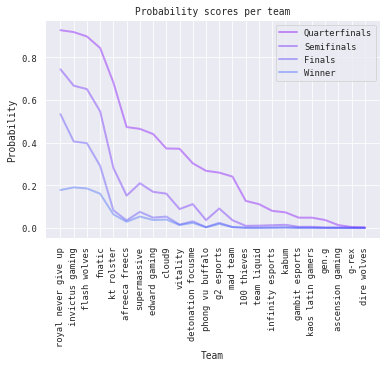

In [26]:
# The probability of getting into a competition stage for the different teams
colors = cm.rainbow(np.linspace(0, 1, len(summary_dict)))
for i, col in enumerate(summary_dict.columns[1:]):
    plt.plot(summary_dict['Team'], summary_dict[col], color=colors[i], alpha=0.4,  linewidth=2, label=col)
plt.legend(loc='best')
plt.title("Probability scores per team")
plt.ylabel('Probability')
plt.xlabel('Team')
plt.xticks(rotation = 90)
plt.show()

In [27]:
# Extract table for creation of conditional probability plot
cond_dict = conditional_probability_creator(simulations_worlds, list(summary_dict.iloc[:5, 0]))
cond_dict

,Team,Quarterfinals,Semifinals,Finals
0,royal never give up,0.802060,0.716916,0.332964
1,invictus gaming,0.726247,0.607344,0.468436
2,flash wolves,0.725077,0.610128,0.465451
3,fnatic,0.647581,0.531300,0.551347
4,kt rolster,0.412149,0.293095,0.768193


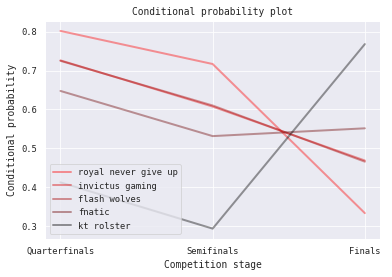

In [28]:
# Visualization of difference in conditional prob at the different competition stages
colors = cm.flag(np.linspace(0, 1, len(cond_dict)))
for i, team in enumerate(cond_dict['Team']):
    plt.plot(cond_dict.iloc[i,1:], color=colors[i], alpha=0.4,  linewidth=2, label=team)
plt.legend(loc='best')
plt.title("Conditional probability plot")
plt.ylabel('Conditional probability')
plt.xlabel('Competition stage')
plt.show()

#### 2.3.2 Most probably competition course

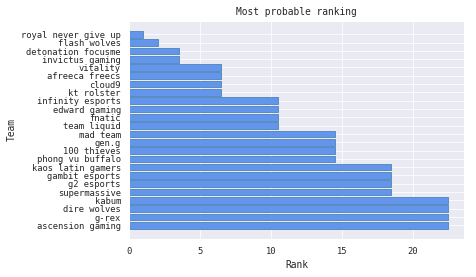

In [29]:
# Most probable competition course
if most_occuring_rank(simulations_worlds):
    most_occurring_scenario_dict = most_occuring_rank(simulations_worlds)
    ID_max = max(most_occurring_scenario_dict.items(), key=operator.itemgetter(1))[0]
    most_occurring_scenario_dict = {team:score for team, score in list(simulations_worlds[ID_max])}

    # Visualization
    rank_visualizer(most_occurring_scenario_dict, 'Most probable ranking')

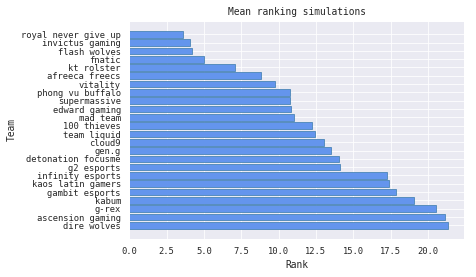

In [30]:
# Check: Mean of ranking based on all simulations
scenario_mean_dict = ranking_summary_creator(simulations_worlds)

# Visualization
rank_visualizer(scenario_mean_dict, 'Mean ranking simulations')

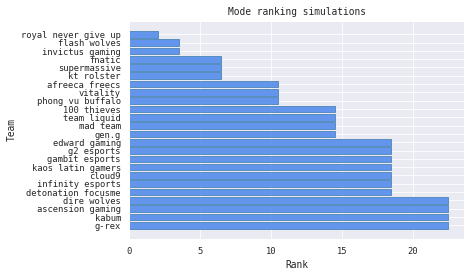

In [31]:
# Check: Mode of ranking based on all simulations
scenario_mode_dict = ranking_summary_creator(simulations_worlds, False)

# Visualization
rank_visualizer(scenario_mode_dict, 'Mode ranking simulations')

## 3. Ranking accuracy evaluation

In [32]:
# Comparison with mean ranking over simulations
sorted_scenario_mean_dict = sorted(scenario_mean_dict.items(), key=operator.itemgetter(1))
simulated_rankings_pred = {t[0]:r for t, r in zip(sorted_scenario_mean_dict, rank_list)}

In [33]:
# Initialization
rank_mapping_dict = {1:1, 2:2, 3.5: 3, 6.5: 4, 10.5: 5, 14.5: 6, 18.5: 7, 22.5: 8}

# Map each team with approximate rank
actual_rankings = {team:rank_mapping_dict[rank] for team, rank in ranking_worlds2018_tmp.items()}
predicted_rankings = {team:rank_mapping_dict[rank] for team, rank in simulated_rankings_pred.items()}
sorted_predicted_rankings = sorted(predicted_rankings.items(), key=operator.itemgetter(1))

# Create combined dictionary with actual and predicted scores
rankings_comb_dict = {team:(actual_rankings[team], predicted_rankings[team]) for team in list([x for x, y in sorted_predicted_rankings])}
a_ranks = [act for act, pred in rankings_comb_dict.values()]
p_ranks = [pred for act, pred in rankings_comb_dict.values()]

In [34]:
# Data visualization
preds_comp_df = pd.DataFrame({'Team': [x for x, y in sorted_predicted_rankings],
                              'Actual scores': a_ranks,
                              'Predicted scores': p_ranks})
preds_comp_df

,Team,Actual scores,Predicted scores
0,royal never give up,4,1
1,invictus gaming,1,2
2,flash wolves,5,3
3,fnatic,2,3
4,kt rolster,4,4
5,afreeca freecs,4,4
6,vitality,5,4
7,phong vu buffalo,6,4
8,supermassive,7,5
9,edward gaming,4,5


In [35]:
# Write predictions away in csv
preds_comp_df.to_csv('csv/preds_comp.csv', sep=',', na_rep='', header=True, index = False)

In [36]:
def accuracy(actual, predicted, k):
    comp_list = [1 if a == p else 0 for a, p in zip(actual, predicted)]
    return sum(comp_list[:k])/len(comp_list[:k])

### 3.1 Accuracy at k
Accuracy evaluated only up to the k-th prediction.

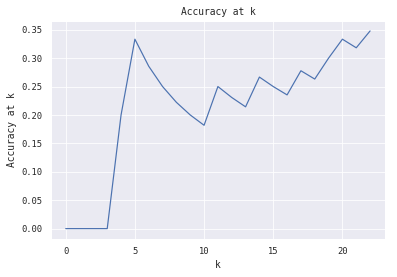

In [37]:
# The change in precision at k with increasing k
plt.plot([accuracy(a_ranks, p_ranks, i) for i in range(1, len(a_ranks))])
plt.title("Accuracy at k")
plt.ylabel('Accuracy at k')
plt.xlabel('k')
plt.show()

### 3.2 Mean accuracy over simulations

In [38]:
# Initialization
accuracies_list = []

# Loop through the simulated rankings
for sim_ranks in simulations_worlds:
    # Extract simulated rankings
    simulated_rankings_pred = dict(simulations_worlds[sim_ranks])
    
    # Define dictionaries for comparing simulated with actual rankings
    actual_rankings = {team:rank_mapping_dict[rank] for team, rank in ranking_worlds2018_tmp.items()}
    predicted_rankings = {team:rank_mapping_dict[rank] for team, rank in simulated_rankings_pred.items()}
    sorted_predicted_rankings = sorted(predicted_rankings.items(), key=operator.itemgetter(1))

    # Create combined dictionary with actual and predicted scores
    rankings_comb_dict = {team:(actual_rankings[team], predicted_rankings[team]) for team in list([x for x, y in sorted_predicted_rankings])}
    a_ranks = [act for act, pred in rankings_comb_dict.values()]
    p_ranks = [pred for act, pred in rankings_comb_dict.values()]
    
    # Add accuracy measurement to list
    accuracies_list.append(accuracy(a_ranks, p_ranks, len(a_ranks)))

Overview of variable:  Ranking accuracy over simulations 


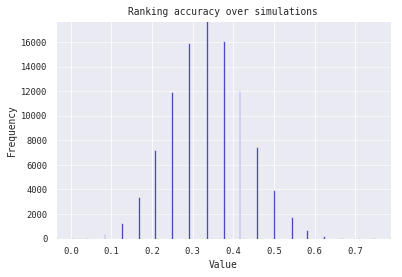

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3373
Standard deviation: 0.0933
Median: 0.3333
Maximal value: 0.75


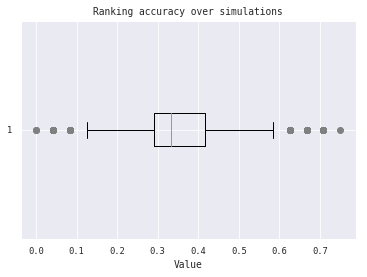

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.67, 0.62, 0.71, 0.75, 0.0, 0.04}


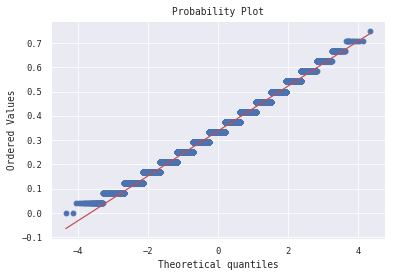

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1031
Kurtosis: -0.0683


In [39]:
# Data visualization
SummaryNumericVar(accuracies_list, 'Ranking accuracy over simulations')

### 3.2  Discounted cumulative gain (DCG)
DCG is a measure of ranking quality. Using a graded scale of documents in a search-engine result set, DCG measures the usefulness, or gain, of a document based on its position in the result list. The gain is accumulated from the top of the result list to the bottom, with the gain of each result discounted at lower ranks. 

In [40]:
a_ranks

[5, 1, 7, 4, 4, 4, 2, 6, 6, 5, 3, 5, 7, 6, 5, 4, 8, 7, 3, 7, 8, 8, 6, 8]

In [41]:
k = 10
sum([(2**a -1)/ math.log(i + 1 + 1, 2) for i, a in enumerate(a_ranks)])

536.5571454569765